# **Download VSBData**

Faults in electric transmission lines can lead to a destructive phenomenon called partial discharge. If left alone, partial discharges can damage equipment to the point that it stops functioning entirely. Your challenge is to detect partial discharges so that repairs can be made before any lasting harm occurs.

Each signal contains 800,000 measurements of a power line's voltage, taken over 20 milliseconds. As the underlying electric grid operates at 50 Hz, this means each signal covers a single complete grid cycle. The grid itself operates on a 3-phase power scheme, and all three phases are measured simultaneously.

In [2]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c vsb-power-line-fault-detection -f train.parquet
!kaggle competitions download -c vsb-power-line-fault-detection -f metadata_train.csv

from zipfile import ZipFile
zip1 = ZipFile('/content/train.parquet.zip')
zip1.extractall('/content/vsb_data/')
# # zip1 = ZipFile('/content/test.parquet.zip')
# # zip1.extractall('/content/vsb_data/')

!rm /content/train.parquet.zip
# !rm /content/test.parquet.zip

Saving kaggle.json to kaggle (1).json
-rw-r--r-- 1 root root 68 Dec 21 22:31 kaggle.json
100% 3.02G/3.02G [00:50<00:00, 22.7MB/s]
100% 3.02G/3.02G [00:50<00:00, 64.5MB/s]
  0% 0.00/115k [00:00<?, ?B/s]
100% 115k/115k [00:00<00:00, 42.9MB/s]


# Importing necessary libraries

In [4]:
import os
import numpy as np
import pyarrow.parquet as pq
import pandas as pd
from tqdm import tqdm_notebook
from scipy import signal as sgn
import matplotlib.pyplot as plt
!pip install torch-summary
from torchsummary import summary

**Create Spectrogram of images, for demo purpose we will create spectrogram of only 432(144x3) train and 432(144x3) test data**
<br> **[~10 Minutes] 

Check Spectrogram arguments here:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html

In [ ]:
cfg = {
    'train_csv_path' : '/content/metadata_train.csv',
    'train_parquet_path' : '/content/vsb_data/train.parquet',
    'test_csv_path' : '/content/metadata_test.csv',
    'test_parquet_path' : '/content/vsb_data/test.parquet',
    'npy_data_dir' : '/content/npy_data/',
    }
 
def min_max_transf(ts, min_data=-128, max_data=127, range_needed=(-1,1)):    
    if min_data < 0:
        ts_std = (ts + abs(min_data)) / (max_data + abs(min_data))
    else:
        ts_std = (ts - min_data) / (max_data - min_data)    
    if range_needed[0] < 0:    
        return ts_std * (range_needed[1] + abs(range_needed[0])) + range_needed[0]
    else:
        return ts_std * (range_needed[1] - range_needed[0]) + range_needed[0]
    
def process_data(mode, csv_path, parq_path, npy_dir, limit=None):
    assert mode in ['train', 'test']
    
    df = pd.read_csv(csv_path)
    if limit==None:
      limit=df.shape[0]
    
    if mode == 'train':
        train_labels = np.zeros([limit//3, 3])
    else:
        test_signal_ids = np.zeros([limit//3, 4])
        
    fnum = 0
    for i in tqdm_notebook(range(0, df.shape[0], 3)):
        if i == limit:
            break
 
        if mode == 'train':
            train_labels[i//3,0] = df.iloc[i].target
            train_labels[i//3,1] = df.iloc[i+1].target
            train_labels[i//3,2] = df.iloc[i+2].target
        else:
            test_signal_ids[i//3,0] = df.iloc[i].signal_id
            test_signal_ids[i//3,1] = df.iloc[i+1].signal_id
            test_signal_ids[i//3,2] = df.iloc[i+2].signal_id
            test_signal_ids[i//3,3] = fnum
                               
        spectogram_img = []
        for j in range(3):
            if mode == 'train':     
                spectogram_img.append(pq.read_pandas(parq_path, columns=[str(i+j)]).to_pandas().to_numpy().transpose([1,0]))
            else:
                spectogram_img.append(pq.read_pandas(parq_path, columns=[str(8712+i+j)]).to_pandas().to_numpy().transpose([1,0]))
        spectogram_img = np.concatenate(spectogram_img)
                
        freqs, times, Sx = sgn.spectrogram(
                            min_max_transf(spectogram_img), 
                            fs=40000000.0, 
                            window='hanning',
                            nperseg=1536, 
                            detrend='constant', 
                            scaling='spectrum'
                            )
        spectogram_img = np.log10(Sx)
 
        if mode == 'train':
            os.makedirs( npy_dir + '/train/', exist_ok=True)
            np.save( npy_dir + '/train/train_data_{}.npy'.format(fnum), spectogram_img) 
        else:
            os.makedirs( npy_dir + '/test/', exist_ok=True)
            np.save( npy_dir + '/test/test_data_{}.npy'.format(fnum), spectogram_img)
        
        fnum += 1 
          
    if mode == 'train':
        np.save( npy_dir + '/train_labels.npy', train_labels)
    else:
        np.save( npy_dir + '/test_signal_ids.npy', test_signal_ids)
    
        
if __name__ == '__main__':
    process_data( 'train', cfg['train_csv_path'], cfg['train_parquet_path'], cfg['npy_data_dir'])
    process_data( 'test', cfg['test_csv_path'], cfg['test_parquet_path'], cfg['npy_data_dir'] )

# Dataset Distribution

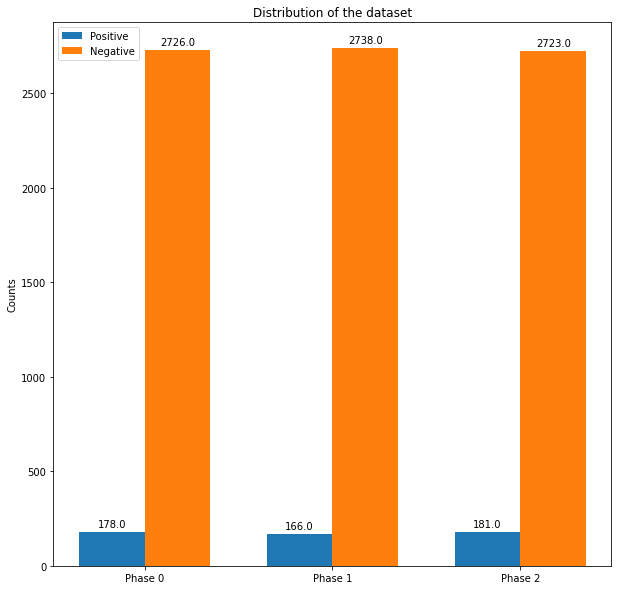

In [31]:
train_labels = np.load('/content/npy_data/train_labels.npy')
labels = ['Phase 0','Phase 1','Phase 2']
positive = np.sum(train_labels,axis=0)
negative= train_labels.shape[0]-positive

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,10))
rects1 = ax.bar(x - width/2, positive, width, label='Positive')
rects2 = ax.bar(x + width/2, negative, width, label='Negative')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Distribution of the dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)

plt.show()

# **Plot two spectrogram images, first two three phase, last one is single phase only**

In [7]:
img1 = np.load('/content/npy_data/train/train_data_0.npy')
img1_n = min_max_transf(img1, -22.53, -1.90, (0,1)).transpose([1,2,0])

In [16]:
sample=np.load('/content/npy_data/train/train_data_0.npy')
sample.shape

(3, 769, 595)

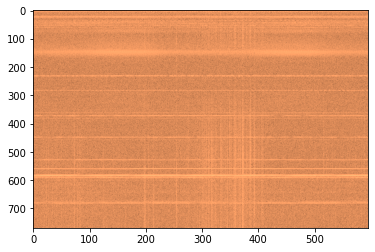

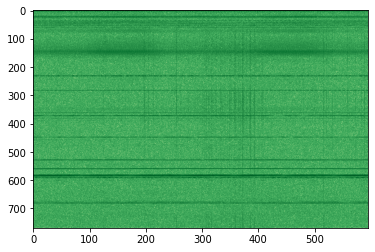

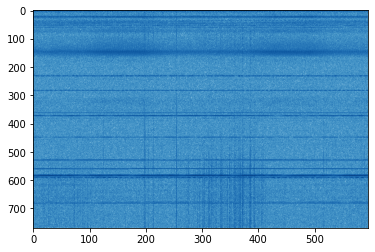

In [ ]:
plt.imshow(img1_n[...,0], cmap='copper',aspect='auto');
plt.show();
plt.imshow(img1_n[...,1], cmap='Greens',aspect='auto');
plt.show();
plt.imshow(img1_n[...,2], cmap='Blues',aspect='auto');
plt.show();

# **Train Begins Here:**
1. Trainer
2. Dataset
3. Model 

**1. Trainer**

In [8]:
import time
import os
import torch
import random
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score

def set_random_state(seed_value):
    random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed_value)
    
class calculate_multilabel_f1_score(object):
    def __init__(self):
        self.reset()
        self.thr = 0.5
    def reset(self):
        self.y_pred = []
        self.y_true = []
    def update(self, y_pred, y_true):
        y_pred[y_pred >= self.thr] = 1
        y_pred[y_pred < self.thr] = 0        
        self.y_pred.append(y_pred)
        self.y_true.append(y_true)        
    def feedback(self):
        self.y_pred = np.concatenate(self.y_pred)
        self.y_true = np.concatenate(self.y_true)
        return f1_score(y_true=self.y_true, y_pred=self.y_pred, average='weighted')

class ModelTrainer():
    def __init__(self, 
                 model=None, 
                 Loaders=[None,[]], 
                 fold=None, 
                 lr=None, 
                 epochsTorun=None,
                 checkpoint_saving_path=None,
                 ):     
        super(ModelTrainer, self).__init__()
                   
        self.model = model.cuda()
        self.trainLoader = Loaders[0]
        self.valLoader = Loaders[1]        
        self.fold = fold                               
        self.checkpoint_saving_path = checkpoint_saving_path + '/fold' + str(self.fold) + '/'      
        os.makedirs(self.checkpoint_saving_path,exist_ok=True)
        
        self.lr = lr
        self.epochsTorun = epochsTorun       

        self.best_loss = 9999
        self.best_f1_score = -9999         

        self.optimizer = torch.optim.Adam(params=self.model.parameters(),lr=self.lr, weight_decay=0.0001)     
        self.scheduler = ReduceLROnPlateau(self.optimizer, factor=0.5, mode='min', patience=3, verbose=True)                 
        self.criterion = nn.BCEWithLogitsLoss().cuda()
                                                       
    def fit(self):                                       
        self.train_metric_meter = calculate_multilabel_f1_score() 
        self.val_metric_meter = calculate_multilabel_f1_score()
        self.train_loss_history=[]
        self.val_loss_history=[]            
        for epoch in range(self.epochsTorun):
            self.train_metric_meter.reset()
            self.val_metric_meter.reset()
                                                                       
            self.model.train()
            torch.set_grad_enabled(True) 
            train_loss = []                                             
            for itera_no, data in enumerate(self.trainLoader):                                                   
                images, targets = data
                images = images.cuda() 
                targets = targets.cuda()                                     
                                    
                out = self.model(images)                    
                batch_loss = self.criterion(out, targets)

                self.optimizer.zero_grad()
                batch_loss.backward() 
                self.optimizer.step()
                                        
                self.train_metric_meter.update(out.detach().cpu().sigmoid().data.numpy(), targets.detach().cpu().data.numpy())                
                train_loss.append(batch_loss.detach().item())                                                                                       
                torch.cuda.empty_cache()
            train_loss = sum(train_loss)/len(train_loss)
            self.train_loss_history.append(train_loss)

                                                                                                               
            self.model.eval()
            torch.set_grad_enabled(False) 
            val_loss = []                               
            with torch.no_grad():
                for itera_no, data in enumerate(self.valLoader):              
                    images, targets = data
                    images = images.cuda() 
                    targets = targets.cuda()                                              
                                                            
                    out = self.model(images)                    
                    batch_loss = self.criterion(out, targets)
                    
                    self.val_metric_meter.update(out.detach().cpu().sigmoid().data.numpy(), targets.detach().cpu().data.numpy())
                    val_loss.append(batch_loss.detach().item())                                       
                    torch.cuda.empty_cache() 
            val_loss = sum(val_loss)/len(val_loss)
            self.train_loss_history.append(val_loss)                    

            print('Current Epoch No - {} :'.format(epoch))
            

            if self.best_loss > val_loss:
                print( ' Val Loss is improved from {:.4f} to {:.4f}! '.format(self.best_loss,val_loss) )
                self.best_loss = val_loss
                is_best_loss = True
            else:
                print( ' Val Loss is not improved from {:.4f}! '.format(self.best_loss))
                is_best_loss = False
                
            val_f1_score = self.val_metric_meter.feedback()
            if self.best_f1_score < val_f1_score:
                print( ' Val f1_score is improved from {:.4f} to {:.4f}! '.format(self.best_f1_score, val_f1_score) )
                self.best_f1_score = val_f1_score
                is_best_f1_score = True
            else:
                print( ' Val f1_score is not improved from {:.4f}! '.format(self.best_f1_score))
                is_best_f1_score = False


            self.scheduler.step(val_loss)
                                    
            checkpoint_dict = {
                'Model_state_dict': self.model.state_dict(),
                'Current_val_Loss': val_loss,
                'Current_train_Loss': train_loss,
                'Current_val_f1_score':val_f1_score,
                'Current_train_f1_score':self.train_metric_meter.feedback(),
                'Best_val_loss' : self.best_loss,
                'Best_val_f1_score':self.best_f1_score,               
                }
                                                
            if is_best_loss:                    
                torch.save(checkpoint_dict, self.checkpoint_saving_path+'checkpoint_best_loss.pth')
            
            if is_best_f1_score:                                    
                torch.save(checkpoint_dict, self.checkpoint_saving_path+'checkpoint_best_f1_score.pth')
                
            del checkpoint_dict
            torch.cuda.empty_cache()

**2. Dataset**

In [9]:
import numpy as np
import librosa
import torch
from torch.utils.data import Dataset, DataLoader


### Load the file names of saved spectrograms and targets
def get_train_fname_labels(npy_dir):
    all_labels = np.load(npy_dir + '/train_labels.npy')
    all_fnames = []
    for i in range(len(os.listdir(npy_dir + '/train/'))):
        all_fnames.append(npy_dir + '/train/train_data_{}.npy'.format(i))
    return np.array(all_fnames), all_labels

class VSBDataset(Dataset):
    def __init__(self, fnames, labels, mode):
        super(VSBDataset).__init__()
        self.fnames = fnames
        self.labels = labels
        self.mode = mode        
    def __len__(self):
        return self.fnames.shape[0]        
    def __getitem__(self, index):
        img = np.load(self.fnames[index])
        img = min_max_transf(img, -22.53, -1.90, (0,1))
        return torch.tensor(img).float(), torch.tensor(self.labels[index]).float()

**3. Model**

In [10]:
import torch
import torch.nn as nn

def get_conv_block(num_channels=32, kernel_size=(7,7), stride=(1,3), pad=(3,0)):
    return nn.Sequential(
                nn.Conv2d(3, num_channels, kernel_size, stride, pad),
                nn.ReLU(),
                nn.BatchNorm2d(num_channels),
                nn.Conv2d(num_channels, 3, kernel_size, stride, pad),
                nn.ReLU(),
                nn.BatchNorm2d(3),
                )

class Frequency_Attn_Block(nn.Module):
    def __init__(self, input_feat_size):        
        super(Frequency_Attn_Block, self).__init__()
        self.fa_block = nn.Sequential(
                              nn.Linear(input_feat_size, input_feat_size//2),
                              nn.ReLU(),
                              nn.Linear(input_feat_size//2, input_feat_size),
                              nn.ReLU(),
                              nn.Linear(input_feat_size, 1),
                              nn.Sigmoid(),                    
                              )
        self.bn = nn.BatchNorm2d(3)                                                                
    def forward(self, x):                
        fa_block_out = torch.mean(x, dim=1)
        fa_block_out = self.fa_block(fa_block_out)
        fa_block_out = fa_block_out.unsqueeze(1) * x                
        return self.bn(fa_block_out)

class Phase_Attn_Block(nn.Module):
    def __init__(self, input_feat_size):        
        super(Phase_Attn_Block, self).__init__()
        self.pa_block = nn.Sequential(
                              nn.Linear(input_feat_size, input_feat_size//2),
                              nn.ReLU(),
                              nn.Linear(input_feat_size//2, input_feat_size),
                              nn.ReLU(),
                              nn.Linear(input_feat_size, 1),
                              nn.Sigmoid(),                    
                              )
        self.bn = nn.BatchNorm2d(3)                                                                
    def forward(self, x):                
        pa_block_out = torch.mean(x, dim=-1)
        pa_block_out = self.pa_block(pa_block_out)
        pa_block_out = pa_block_out.unsqueeze(3) * x        
        return self.bn(pa_block_out)

class CNN_Model(nn.Module):
    def __init__(self, f_dim=769):        
        super(CNN_Model, self).__init__()
        self.backbone = nn.Sequential(
                              get_conv_block(num_channels=32, kernel_size=(7,7), stride=(1,3), pad=(3,0)),
                              Phase_Attn_Block(f_dim),
                              Frequency_Attn_Block(64),
                              get_conv_block(num_channels=64, kernel_size=(5,5), stride=(1,2), pad=(2,0)),
                              Phase_Attn_Block(f_dim),
                              Frequency_Attn_Block(13),
                              ) 
                                        
        self.head = nn.Sequential(
                        nn.Dropout(p=0.3),
                        nn.BatchNorm1d(f_dim),
                        nn.Linear(f_dim, f_dim//2),
                        nn.Dropout(p=0.3),
                        nn.BatchNorm1d(f_dim//2),
                        nn.Linear(f_dim//2, 3)
                        ) 
                                                                
    def forward(self, x):       
        out = self.backbone(x)
        out = torch.mean(out, dim=-1)
        out = torch.mean(out, dim=1)        
        out = self.head(out)               
        return out

In [ ]:
model = CNN_Model()
sample=np.load('/content/npy_data/train/train_data_0.npy')
summary(model, sample.shape)

In [25]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader

cfg = {
    'npy_data_dir' : '/content/npy_data/',
    'random_seed' : 4690,
    'n_folds' : 5,
    'batch_size' : 48,
    'n_core' : 0,
    'weight_saving_path' : '/content/weights/model_demo/',
    'lr' : 0.001,
    'total_epochs' : 2,
    }

if __name__ == '__main__':
    set_random_state(cfg['random_seed'])
    all_fnames, all_labels = get_train_fname_labels(cfg['npy_data_dir'])
    all_labels = all_labels[0:all_fnames.shape[0],...]
    
    skf = StratifiedKFold(n_splits=cfg['n_folds'], shuffle=True, random_state=cfg['random_seed'])
    for fold_number, (train_index, val_index) in enumerate(skf.split(X=all_fnames, y=all_labels.sum(1))):            
        if fold_number != 0:
            break
        
        train_dataset = VSBDataset(
                            all_fnames[train_index], 
                            all_labels[train_index],
                            'train',
                            )        
        val_dataset = VSBDataset(
                            all_fnames[val_index], 
                            all_labels[val_index], 
                            'val',
                            )                    
        train_loader = DataLoader(
                            train_dataset, 
                            batch_size=cfg['batch_size'], 
                            shuffle=True, 
                            num_workers=cfg['n_core'],
                            drop_last=True,
                            pin_memory=True,
                            )
        val_loader = DataLoader(
                            val_dataset, 
                            batch_size=cfg['batch_size'], 
                            shuffle=False, 
                            num_workers=cfg['n_core'],
                            pin_memory=True,
                            )
    
        model = CNN_Model()
        
        args = { 
                'model': model,
                'Loaders': [train_loader,val_loader],                     
                'checkpoint_saving_path': cfg['weight_saving_path'],
                'lr': cfg['lr'],
                'fold': fold_number,
                'epochsTorun': cfg['total_epochs'],
                }
                    
        Trainer = ModelTrainer(**args)
        Trainer.fit() 